# Study 3 – Dataset characterisation and signal quality analysis

This notebook implements Study 3 of the thesis, focusing on:
- Global characterisation of the ePatch ECG dataset
- Seizure distribution and inter-seizure intervals
- Segment-level labelling (seizure vs. baseline) using fixed 60 s windows
- Signal quality and noise characteristics using SQI and spectral metrics
- Peri-ictal windows around seizures (legacy window scheme)
- Illustrative case studies and visualisations


## Imports

In [6]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
from dataclasses import asdict

# Project style
from src.hrv_epatch.plots.plotstyle import set_project_style
set_project_style()  # ensartet grøn stil på alle plots

# Dataset-API
from src.hrv_epatch.dataset.index import build_recording_index
from src.hrv_epatch.dataset.loader import iter_recordings
from src.hrv_epatch.dataset.seizures import build_seizure_events_from_df, SeizureEvent
from src.hrv_epatch.dataset.segments import build_segment_index
from src.hrv_epatch.dataset.summary import (
    compute_dataset_overview,
    build_patient_summary,
    compute_within_recording_isi,
    summarise_isi,
)


# IO / TDMS
from src.hrv_epatch.io.tdms import load_tdms_from_path, TdmsMeta

# SQI og noise metrics
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    SQIThresholds,
    compute_sqi_for_many_segments,
    classify_many_segments,
)
from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

# Frequenzy / PSD
from src.hrv_epatch.features.frequency import (
    compute_psd,
    summarize_psd_bands,
    plot_psd,
)

# Seizure-windows (peri-ictal)
from src.hrv_epatch.seizure.windows import analyze_shifted_windows

# Plots
from src.hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from src.hrv_epatch.plots.rpeak import plot_raw_vs_clean_with_peaks

# Eventually: Jeppesen/HRV-pipeline if needed
# from src.hrv_epatch.rpeak.jeppesen_pipeline import run_pipeline_from_ecg

from src.hrv_epatch.dataset.dataset_builders import build_df_rec_and_df_evt
from src.hrv_epatch.dataset.peri_windows import build_peri_windows_for_recording

from src.hrv_epatch.preprocessing.denoise_metrics import noise_metrics

from src.hrv_epatch.features.frequency import compute_psd, summarize_psd_bands
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
)
from src.hrv_epatch.sqi.sqi_bukhari import compute_sqi_for_many_segments
from src.hrv_epatch.plots.peri_noise import plot_peri_noise_feature
from src.hrv_epatch.features.hrv_peri import compute_hrv_for_many_segments
from src.hrv_epatch.plots.peri_sqi import plot_peri_sqi_score

plt.close("all")
pd.options.display.max_columns = 50


## Configuration

In [7]:
# >>> Tilpas disse til din lokale struktur <<<
BASE_DIR = Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne")
TDMS_ROOT = BASE_DIR / "Patients ePatch data"
ANN_ROOT = BASE_DIR / "Seizure log ePatch patients with seizures - excluded seizures removed"

OUT_DIR = Path(r"E:\Speciale - Results") / "_analysis" / "study3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Segment- og vinduesparametre
SEGMENT_LEN_S = 60.0  # faste 60 s segmenter til global karakterisering
PERIICTAL_OFFSETS_MIN = [-20, -2, 0, 2, 20]  # eksempel-værdier, kan tweakes
PERIICTAL_WINDOW_LEN_S = 60.0  # længde af hver peri-ictal vindue
FS_FALLBACK = 512.0


## 1. Build recording index

We first construct a structured index of all TDMS recordings and their corresponding
annotation files using the `hrv_epatch.dataset.index` module.

In [8]:
recording_index = build_recording_index(TDMS_ROOT, ANN_ROOT)
recording_index[:5]

[RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=1), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 1/Patient 1_1.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=1, enrollment_id=None, recording_id=2), tdms_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Patients ePatch data/Patient 1/recording 2/Patient 1_2.tdms'), annotation_path=WindowsPath('E:/ML algoritme tl anfaldsdetektion vha HRV/ePatch data from Aarhus to Lausanne/Seizure log ePatch patients with seizures - excluded seizures removed/patient 1.xls')),
 RecordingEntry(key=RecordingKey(patient_id=2, enrollment_id=None, recording_id=1), tdms_path=WindowsPath(

In [9]:
entries = build_recording_index(TDMS_ROOT, ANN_ROOT)

print("Antal entries:", len(entries))
for e in entries[:10]:
    print(
        "UID:",
        f"P{e.key.patient_id:02d}{e.key.enrollment_id or ''}_R{e.key.recording_id:02d}",
        "| TDMS:", e.tdms_path.name,
        "| ANN:", e.annotation_path.name if e.annotation_path is not None else None,
    )


Antal entries: 72
UID: P01_R01 | TDMS: Patient 1_1.tdms | ANN: patient 1.xls
UID: P01_R02 | TDMS: Patient 1_2.tdms | ANN: patient 1.xls
UID: P02_R01 | TDMS: Patient 2_1.tdms | ANN: patient 2.xls
UID: P03_R01 | TDMS: Patient 3_1.tdms | ANN: patient 3.xls
UID: P03_R02 | TDMS: Patient 3_2.tdms | ANN: patient 3.xls
UID: P04_R01 | TDMS: Patient 4_1.tdms | ANN: patient 4.xls
UID: P05_R01 | TDMS: Patient 5_1.tdms | ANN: patient 5.xls
UID: P06_R01 | TDMS: Patient 6_1.tdms | ANN: patient 6.xls
UID: P06_R02 | TDMS: Patient 6_2.tdms | ANN: patient 6.xls
UID: P07_R01 | TDMS: Patient 7_1.tdms | ANN: patient 7.xls


## 1.1 Build recording- and event-level tables

We iterate over all recordings and build:
- `df_rec`: one row per recording (duration, patient/enrollment, etc.)
- `df_evt`: one row per seizure event (absolute start/stop, recording ID, etc.)

In [10]:
df_rec, df_evt = build_df_rec_and_df_evt(TDMS_ROOT, ANN_ROOT, test_mode=False)
print(len(df_rec), "recordings")
print(len(df_evt), "seizure events")
print(df_rec.head())
print(df_evt.head())

[INFO] P01_R01: 1 seizures
[INFO] P01_R02: 2 seizures
[INFO] P02_R01: 9 seizures
[INFO] P03_R01: 2 seizures
[INFO] P03_R02: 1 seizures
[INFO] P04_R01: 1 seizures
[INFO] P05_R01: 3 seizures
[INFO] P06_R01: 1 seizures
[INFO] P06_R02: 0 seizures
[INFO] P07_R01: 3 seizures
[INFO] P07_R02: 1 seizures
[INFO] P08a_R01: 1 seizures
[INFO] P08a_R02: 0 seizures
[INFO] P08b_R01: 1 seizures
[INFO] P09_R01: 3 seizures
[INFO] P09_R02: 0 seizures
[INFO] P10_R01: 1 seizures
[INFO] P11_R01: 2 seizures
[INFO] P11_R02: 4 seizures
[INFO] P12_R01: 2 seizures
[INFO] P12_R02: 1 seizures
[INFO] P13_R01: 1 seizures
[INFO] P13_R02: 7 seizures
[INFO] P14_R01: 0 seizures
[INFO] P14_R02: 7 seizures
[INFO] P15_R01: 0 seizures
[INFO] P15_R02: 1 seizures
[INFO] P16_R01: 1 seizures
[INFO] P17_R01: 1 seizures
[INFO] P18_R01: 3 seizures
[INFO] P19_R01: 3 seizures
[INFO] P20_R01: 4 seizures
[INFO] P20_R02: 2 seizures
[INFO] P21_R01: 1 seizures
[INFO] P21_R02: 0 seizures
[INFO] P22_R01: 0 seizures
[INFO] P22_R02: 5 seizure

Grov støjanalyse til at foreslå trim (start/slut)

In [11]:
# Export df_rec as CSV and Parquet for use in other analyses
# df_rec.to_csv(r"E:\Speciale - Results\df_rec.csv", index=False)
# df_rec.to_parquet(r"E:\Speciale - Results\df_rec.parquet")

In [12]:
from src.hrv_epatch.rpeak.trim_estimator import estimate_trim_from_rms
from src.hrv_epatch.io.tdms import load_tdms_from_path

import pandas as pd
from tqdm import tqdm

# Parametre der nu virker stabilt
TRIM_PARAMS = dict(
    rms_factor=2.5,
    min_clean_run_start_s=120.0,
    min_clean_run_end_s=120.0,
    edge_start_span_s=20*60.0,
    edge_end_span_s=20*60.0,
    pre_clean_before_start_s=10.0,
    post_clean_after_end_s=10.0,
    win_s=10.0,
    step_s=5.0,
)

trim_rows = []

print(f"Kører trim-estimation på {len(df_rec)} recordings...")

for idx, row in tqdm(df_rec.iterrows(), total=len(df_rec)):
    tdms_path = row["tdms_path"]
    
    # Load signal
    sig, meta = load_tdms_from_path(
        tdms_path,
        channel_hint="EKG",
        prefer_tz="Europe/Copenhagen",
        assume_source_tz="Europe/Copenhagen",
    )

    fs = meta.fs
    
    # Compute trim
    trim_start_s, trim_end_s = estimate_trim_from_rms(sig, fs, **TRIM_PARAMS)

    trim_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "recording_id": row["recording_id"],
        "trim_start_s": trim_start_s,
        "trim_end_s": trim_end_s,
        "signal_duration_s": len(sig)/fs,
        "tdms_path": tdms_path,
    })

df_trim = pd.DataFrame(trim_rows)

df_trim["trim_start_s"] = df_trim["trim_start_s"].round().astype(int)
df_trim["trim_end_s"] = df_trim["trim_end_s"].round().astype(int)

df_trim.head()


Kører trim-estimation på 72 recordings...


100%|██████████| 72/72 [06:46<00:00,  5.64s/it]


,recording_uid,patient_id,recording_id,trim_start_s,trim_end_s,signal_duration_s,tdms_path
0,P01_R01,1,1,140,226,191135.750000,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...
1,P01_R02,1,2,10,240,146700.001953,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...
2,P02_R01,2,1,90,65,63884.750000,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...
3,P03_R01,3,1,130,78,171022.500000,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...
4,P03_R02,3,2,55,77,168802.000000,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...


In [13]:
df_trim.head()
print("\nUnique patients:", df_trim.patient_id.nunique())
print("Total recordings:", len(df_trim))



Unique patients: 43
Total recordings: 72


In [14]:
# ---------------------------------------
# EXPORT TRIM TABLE
# ---------------------------------------

OUTPUT_DIR = r"E:\Speciale - Results\trim_tables"
os.makedirs(OUTPUT_DIR, exist_ok=True)

csv_path = os.path.join(OUTPUT_DIR, "trim_table.csv")
xlsx_path = os.path.join(OUTPUT_DIR, "trim_table.xlsx")
pkl_path = os.path.join(OUTPUT_DIR, "trim_table.pkl")

# CSV (LabVIEW)
df_trim.to_csv(csv_path, index=False)

# Excel (Documenting + manual edits)
df_trim.to_excel(xlsx_path, index=False)

# Pickle (fast reload in Python)
df_trim.to_pickle(pkl_path)

print("Saved:")
print(" -", csv_path)
print(" -", xlsx_path)
print(" -", pkl_path)


Saved:
 - E:\Speciale - Results\trim_tables\trim_table.csv
 - E:\Speciale - Results\trim_tables\trim_table.xlsx
 - E:\Speciale - Results\trim_tables\trim_table.pkl


In [15]:
# Load the trim table again (if needed)
print(df_rec.shape)

(72, 11)


In [17]:
df_rec[["recording_uid", "patient_id", "recording_start", "recording_end", "rec_duration_s"]].head()
print(df_rec.shape)

(72, 11)


In [18]:
## ----- EXTRA ------ Chose responders or non-responders
responder_ids = [3,5,6,8,10,14,15,16,21,23,27,28,29,31,34,37,39,40,41,42]
non_responder_ids = [1,2,4,7,9,11,12,13,17,18,19,20,22,24,25,26,30,32,33,35,36,38,43]

df_rec = df_rec[df_rec["patient_id"].isin(responder_ids)]

print(df_rec.shape)

(37, 11)


## 1.2 Segment index with fixed windows

We now discretise each recording into non-overlapping 60 s segments and
label each segment as `seizure` or `baseline` depending on overlap with any seizure.
This forms the basis for segment-level statistics and SQI.


In [19]:
segment_index = build_segment_index(df_rec, df_evt, window_s=SEGMENT_LEN_S)
segment_index.head()


,segment_id,patient_id,enrollment_id,recording_uid,segment_start,segment_end,label
0,0,3,None,P03_R01,2016-09-05 11:19:32,2016-09-05 11:20:32,baseline
1,1,3,None,P03_R01,2016-09-05 11:20:32,2016-09-05 11:21:32,baseline
2,2,3,None,P03_R01,2016-09-05 11:21:32,2016-09-05 11:22:32,baseline
3,3,3,None,P03_R01,2016-09-05 11:22:32,2016-09-05 11:23:32,baseline
4,4,3,None,P03_R01,2016-09-05 11:23:32,2016-09-05 11:24:32,baseline


In [20]:
all_windows = []

for ridx, rec in df_rec.iterrows():
    rec_uid = rec["recording_uid"]
    tdms_path = rec["tdms_path"]

    sig, meta = load_tdms_from_path(tdms_path, channel_hint="EKG")

    df_evt_rec = df_evt[df_evt["recording_uid"] == rec_uid]

    if df_evt_rec.empty:
        continue

    win_list = build_peri_windows_for_recording(
        sig=sig,
        meta=meta,
        df_evt_rec=df_evt_rec,
        rec_uid=rec_uid,
    )

    all_windows.extend(win_list)

len(all_windows)

348

In [21]:
peri_rows = []

for w in all_windows:
    peri_rows.append({
        "recording_uid": w.recording_uid,
        "patient_id": w.patient_id,
        "seizure_id": w.seizure_id,
        "role": w.role,
        "t_start": w.t_start,
        "t_end": w.t_end,
        "duration_s": w.t_end - w.t_start,
        "fs": w.fs,
        "n_samples": len(w.x),
        "signal": w.x,  # raw ECG segment
    })

df_peri = pd.DataFrame(peri_rows)
df_peri.head()

print(df_peri.shape)

fs = 512
MIN_DURATION_S = 55  # eller 50
MIN_SAMPLES = fs * MIN_DURATION_S

df_peri = df_peri[
    ((df_peri.role == "ictal") | (df_peri.n_samples >= MIN_SAMPLES))
].reset_index(drop=True)

MIN_ICTAL_S = 5  # eller 10, hvis du vil være ekstra konservativ

mask_valid = ~(
    (df_peri["role"] == "ictal") &
    (df_peri["duration_s"] < MIN_ICTAL_S)
)

df_peri_valid = df_peri[mask_valid].reset_index(drop=True)


print(df_peri.shape)
print(df_peri_valid.shape)

(348, 10)
(348, 10)
(348, 10)


One very short ictal event (~2 s) was recorded.
Due to its duration, it was excluded from the peri-ictal feature analysis in Study 3.

In [22]:
df_peri_valid["duration_s"].describe()
df_peri_valid.sort_values("duration_s").head(10)


,recording_uid,patient_id,seizure_id,role,t_start,t_end,duration_s,fs,n_samples,signal
151,P29_R01,29,5,ictal,13514.0,13534.0,20.0,512.0,10240,"[81.29369039444639, 84.04940871290216, 92.3165..."
166,P31a_R01,31,1,ictal,5699.0,5724.0,25.0,512.0,12800,"[-180.49954985885338, -174.9881132219418, -183..."
176,P31a_R01,31,6,ictal,13485.0,13511.0,26.0,512.0,13312,"[23.423605706874856, 20.667887388419068, 17.91..."
2,P03_R01,3,1,ictal,43234.0,43260.0,26.0,512.0,13312,"[-37.20219729915246, -39.95791561760824, -34.4..."
171,P31a_R01,31,2,ictal,8598.0,8624.0,26.0,512.0,13312,"[-2062.655161364156, -2068.1665980010675, -207..."
17,P05_R01,5,1,ictal,73289.0,73316.0,27.0,512.0,13824,"[95.07228198672532, 97.8280003051811, 103.3394..."
7,P03_R01,3,2,ictal,129752.0,129779.0,27.0,512.0,13824,"[106.09515526054847, 108.85087357900426, 114.3..."
136,P29_R01,29,2,ictal,2404.0,2431.0,27.0,512.0,13824,"[-213.56816968032282, -210.81245136186703, -20..."
206,P31a_R01,31,13,ictal,36498.0,36526.0,28.0,512.0,14336,"[-78.53797207598926, -75.78225375753348, -73.0..."
251,P31a_R01,31,26,ictal,120535.0,120563.0,28.0,512.0,14336,"[-163.96523994811866, -161.20952162966287, -15..."


## 2 Extract Features for Each Peri-Ictal window
Noise Features based on denoise_metrics.py

In [23]:
# Beregn noise features for hvert vindue
noise_feature_rows = []

for idx, row in df_peri_valid.iterrows():
    x = row["signal"]
    fs = row["fs"]

    nm = noise_metrics(x, fs)

    noise_feature_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],

        # Basics
        "rms": nm["rms"],
        "line_noise_ratio": nm["line_noise_ratio"],
        "hf_noise_ratio": nm["hf_noise_ratio"],
        "snr_qrs": nm["snr_qrs"],

        # Sub-bands (we extract from nm["bands"])
        "ulf_rel":   nm["bands"].loc[nm["bands"].band=="ULF", "rel_power"].values[0],
        "qrs_rel":   nm["bands"].loc[nm["bands"].band=="QRS", "rel_power"].values[0],
        "hf_rel":    nm["bands"].loc[nm["bands"].band=="HF",  "rel_power"].values[0],
        "line_rel":  nm["bands"].loc[nm["bands"].band=="Line","rel_power"].values[0],
    })

df_noise = pd.DataFrame(noise_feature_rows)
df_noise.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel
0,P03_R01,3,1,baseline_far,210.637327,0.000072,0.001386,0.552275,0.405070,0.355784,0.000493,0.000026
1,P03_R01,3,1,baseline_near,202.085363,0.000094,0.001508,0.608736,0.357251,0.378394,0.000571,0.000036
2,P03_R01,3,1,ictal,599.646820,0.003144,0.044018,0.119810,0.758620,0.106992,0.004710,0.000336
3,P03_R01,3,1,post_near,273.332578,0.000516,0.004729,0.535436,0.403244,0.348719,0.001649,0.000180
4,P03_R01,3,1,post_far,186.527336,0.000117,0.001951,1.100059,0.142168,0.523823,0.001022,0.000061


PSD Features

In [24]:
psd_rows = []

for idx, row in df_peri_valid.iterrows():
    x = row["signal"]
    fs = row["fs"]

    f, Pxx = compute_psd(x, fs)
    bands = summarize_psd_bands(f, Pxx)

    # Convert bands DF -> dictionary
    band_dict = {f"{b.band}_power": b.power for _, b in bands.iterrows()}
    band_dict.update({f"{b.band}_rel": b.rel_power for _, b in bands.iterrows()})

    psd_rows.append({
        "recording_uid": row["recording_uid"],
        "patient_id": row["patient_id"],
        "seizure_id": row["seizure_id"],
        "role": row["role"],
        **band_dict
    })

df_psd = pd.DataFrame(psd_rows)
df_psd.head()


,recording_uid,patient_id,seizure_id,role,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel
0,P03_R01,3,1,baseline_far,17922.689565,10554.423896,15741.998315,21.812142,1.137642,0.405070,0.238540,0.355784,0.000493,0.000026
1,P03_R01,3,1,baseline_near,13486.331773,9953.211881,14284.483368,21.545038,1.347034,0.357251,0.263659,0.378394,0.000571,0.000036
2,P03_R01,3,1,ictal,249212.299864,42049.752087,35147.501129,1547.128530,110.508775,0.758620,0.128003,0.106992,0.004710,0.000336
3,P03_R01,3,1,post_near,25362.290996,15473.692855,21932.931488,103.715395,11.321012,0.403244,0.246021,0.348719,0.001649,0.000180
4,P03_R01,3,1,post_far,4540.663631,10628.137450,16730.233579,32.632829,1.958542,0.142168,0.332767,0.523823,0.001022,0.000061


SQI Features (Bukhari)

In [25]:
# Alternative approach for each segment:
# sqi_cfg = SQIConfig(fs=512.0)

# sqi_rows = []

# for idx, row in df_peri.iterrows():
#     x = row["signal"]      # numpy-array med ECG
#     # fs er i config, så vi skal ikke sende fs ind her
#     feats = compute_sqi_features_for_segment(x, config=sqi_cfg)

#     sqi_rows.append({
#         "recording_uid": row["recording_uid"],
#         "patient_id": row["patient_id"],
#         "seizure_id": row["seizure_id"],
#         "role": row["role"],
#         **feats,
#     })

# df_sqi = pd.DataFrame(sqi_rows)
# df_sqi.head()

sqi_cfg = SQIConfig(fs=512.0)

# 1) Beregn features for alle vinduer i ét hug
feats_list = compute_sqi_for_many_segments(
    segments=df_peri_valid["signal"].to_list(),
    config=sqi_cfg,
)

# 2) Lav DataFrame af features
df_sqi_feats = pd.DataFrame(feats_list)

# 3) Merge med metadata fra df_peri
df_sqi = pd.concat(
    [
        df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_feats.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi.head()


,recording_uid,patient_id,seizure_id,role,ampdiff,rampdiff,mean_freq,lf_power,hf_power,mains_power,total_power,lf_rel_power,hf_rel_power,mains_rel_power,flat_rampdiff_min,flat_rampdiff_p10
0,P03_R01,3,1,baseline_far,1782.949752,1328.256229,5.677035,7846.030202,21.671499,0.539655,34544.547292,0.227128,0.000627,0.000016,887.341299,913.796194
1,P03_R01,3,1,baseline_near,1631.385245,1165.668849,5.907381,5563.503509,21.186772,0.724545,30173.457700,0.184384,0.000702,0.000024,843.249805,929.503789
2,P03_R01,3,1,ictal,4761.881254,2728.161135,2.947310,151462.310491,1832.065563,61.621458,250826.236071,0.603854,0.007304,0.000246,901.119890,1100.082753
3,P03_R01,3,1,post_near,2557.306600,1818.774090,5.673694,12693.179981,98.147108,4.551388,51634.340301,0.245828,0.001901,0.000088,733.021073,984.067012
4,P03_R01,3,1,post_far,1556.980850,1179.447440,7.110352,1711.358458,33.130576,1.029366,29177.562242,0.058653,0.001135,0.000035,879.074144,928.125930


In [26]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    estimate_sqi_thresholds_from_population,
    classify_many_segments,
)

# 1) Estimér thresholds ud fra feature-dicts
thresholds = estimate_sqi_thresholds_from_population(feats_list)

# 2) Klassificér alle vinduer
class_results = classify_many_segments(
    segments=df_peri_valid["signal"].to_list(),
    config=sqi_cfg,
    thresholds=thresholds,
)

df_sqi_class = pd.DataFrame(class_results)

# 3) Merge metadata + klassifikation
df_sqi_full = pd.concat(
    [
        df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_sqi_class.reset_index(drop=True),
    ],
    axis=1,
)

df_sqi_full.head()


,recording_uid,patient_id,seizure_id,role,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P03_R01,3,1,baseline_far,True,1.0,True,True,True,True,True,True,1782.949752,1328.256229,5.677035,7846.030202,21.671499,0.539655,34544.547292,0.227128,0.000627,0.000016,887.341299,913.796194
1,P03_R01,3,1,baseline_near,True,1.0,True,True,True,True,True,True,1631.385245,1165.668849,5.907381,5563.503509,21.186772,0.724545,30173.457700,0.184384,0.000702,0.000024,843.249805,929.503789
2,P03_R01,3,1,ictal,True,1.0,True,True,True,True,True,True,4761.881254,2728.161135,2.947310,151462.310491,1832.065563,61.621458,250826.236071,0.603854,0.007304,0.000246,901.119890,1100.082753
3,P03_R01,3,1,post_near,True,1.0,True,True,True,True,True,True,2557.306600,1818.774090,5.673694,12693.179981,98.147108,4.551388,51634.340301,0.245828,0.001901,0.000088,733.021073,984.067012
4,P03_R01,3,1,post_far,True,1.0,True,True,True,True,True,True,1556.980850,1179.447440,7.110352,1711.358458,33.130576,1.029366,29177.562242,0.058653,0.001135,0.000035,879.074144,928.125930


Amount of "Good" windows

In [27]:
# Globalt SQI-overblik pr. rolle
sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1_sqi=("sqi_score", lambda x: x.quantile(0.25)),
        q3_sqi=("sqi_score", lambda x: x.quantile(0.75)),
    )
)

sqi_role["frac_good"] = sqi_role["n_good"] / sqi_role["n_windows"]
sqi_role["percent_good"] = 100 * sqi_role["frac_good"]

sqi_role


,n_windows,n_good,median_sqi,q1_sqi,q3_sqi,frac_good,percent_good
role,,,,,,,
baseline_far,69,61,1.0,1.0,1.0,0.884058,88.405797
baseline_near,70,63,1.0,1.0,1.0,0.900000,90.000000
ictal,70,56,1.0,1.0,1.0,0.800000,80.000000
post_far,69,59,1.0,1.0,1.0,0.855072,85.507246
post_near,70,63,1.0,1.0,1.0,0.900000,90.000000


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_16188\3947176332.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=roles_order, showfliers=False)


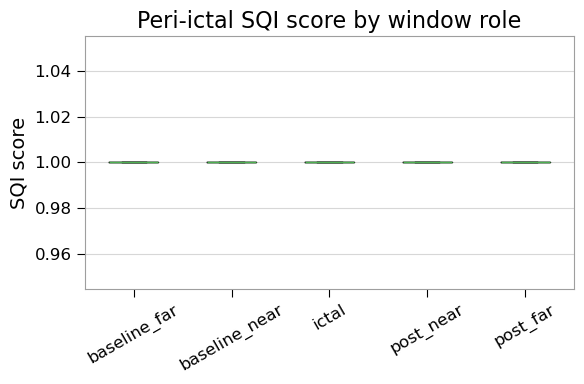

In [28]:
plt.figure(figsize=(6, 4))
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

data = [df_sqi_full.loc[df_sqi_full["role"] == r, "sqi_score"] for r in roles_order]
plt.boxplot(data, labels=roles_order, showfliers=False)

plt.ylabel("SQI score")
plt.title("Peri-ictal SQI score by window role")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


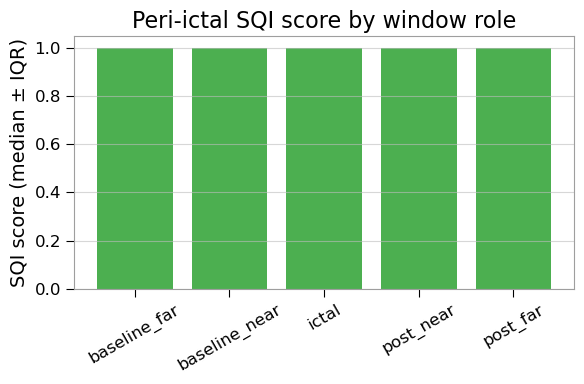

In [29]:
sqi_role_plot = sqi_role.reindex(roles_order)

plt.figure(figsize=(6, 4))
plt.bar(sqi_role_plot.index, sqi_role_plot["median_sqi"], yerr=[
    sqi_role_plot["median_sqi"] - sqi_role_plot["q1_sqi"],
    sqi_role_plot["q3_sqi"] - sqi_role_plot["median_sqi"],
])
plt.ylabel("SQI score (median ± IQR)")
plt.xticks(rotation=30)
plt.title("Peri-ictal SQI score by window role")
plt.tight_layout()
plt.show()


In [30]:
sqi_patient_role = (
    df_sqi_full
    .groupby(["patient_id", "role"])
    .agg(
        n_windows=("is_good", "size"),
        frac_good=("is_good", "mean"),
        median_sqi=("sqi_score", "median"),
    )
    .reset_index()
)

sqi_patient_role.head()


,patient_id,role,n_windows,frac_good,median_sqi
0,3,baseline_far,3,1.0,1.0
1,3,baseline_near,3,1.0,1.0
2,3,ictal,3,1.0,1.0
3,3,post_far,3,1.0,1.0
4,3,post_near,3,1.0,1.0


In [31]:
sqi_ictal = sqi_patient_role[sqi_patient_role["role"] == "ictal"]
sqi_ictal.describe()


,patient_id,n_windows,frac_good,median_sqi
count,20.000000,20.000000,20.000000,20.000000
mean,23.450000,3.500000,0.729762,0.962500
std,13.156847,4.524786,0.362185,0.087505
min,3.000000,1.000000,0.000000,0.666667
25%,13.000000,1.000000,0.571429,1.000000
50%,25.000000,2.500000,0.976190,1.000000
75%,34.750000,3.000000,1.000000,1.000000
max,42.000000,21.000000,1.000000,1.000000


Merge to df_all

In [32]:
# Start med metadata (1 række per vindue)
df_meta = df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True)

# Noise
df_noise_clean = df_noise.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_noise_clean = df_noise_clean.reset_index(drop=True)

# PSD
df_psd_clean = df_psd.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_psd_clean = df_psd_clean.reset_index(drop=True)

# SQI
df_sqi_clean = df_sqi_full.drop(columns=["recording_uid", "patient_id", "seizure_id", "role"])
df_sqi_clean = df_sqi_clean.reset_index(drop=True)

# Merge alt i ét stort datasæt
df_all = pd.concat(
    [
        df_meta,
        df_noise_clean,
        df_psd_clean,
        df_sqi_clean,
    ],
    axis=1
)

df_all.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10
0,P03_R01,3,1,baseline_far,210.637327,0.000072,0.001386,0.552275,0.405070,0.355784,0.000493,0.000026,17922.689565,10554.423896,15741.998315,21.812142,1.137642,0.405070,0.238540,0.355784,0.000493,0.000026,True,1.0,True,True,True,True,True,True,1782.949752,1328.256229,5.677035,7846.030202,21.671499,0.539655,34544.547292,0.227128,0.000627,0.000016,887.341299,913.796194
1,P03_R01,3,1,baseline_near,202.085363,0.000094,0.001508,0.608736,0.357251,0.378394,0.000571,0.000036,13486.331773,9953.211881,14284.483368,21.545038,1.347034,0.357251,0.263659,0.378394,0.000571,0.000036,True,1.0,True,True,True,True,True,True,1631.385245,1165.668849,5.907381,5563.503509,21.186772,0.724545,30173.457700,0.184384,0.000702,0.000024,843.249805,929.503789
2,P03_R01,3,1,ictal,599.646820,0.003144,0.044018,0.119810,0.758620,0.106992,0.004710,0.000336,249212.299864,42049.752087,35147.501129,1547.128530,110.508775,0.758620,0.128003,0.106992,0.004710,0.000336,True,1.0,True,True,True,True,True,True,4761.881254,2728.161135,2.947310,151462.310491,1832.065563,61.621458,250826.236071,0.603854,0.007304,0.000246,901.119890,1100.082753
3,P03_R01,3,1,post_near,273.332578,0.000516,0.004729,0.535436,0.403244,0.348719,0.001649,0.000180,25362.290996,15473.692855,21932.931488,103.715395,11.321012,0.403244,0.246021,0.348719,0.001649,0.000180,True,1.0,True,True,True,True,True,True,2557.306600,1818.774090,5.673694,12693.179981,98.147108,4.551388,51634.340301,0.245828,0.001901,0.000088,733.021073,984.067012
4,P03_R01,3,1,post_far,186.527336,0.000117,0.001951,1.100059,0.142168,0.523823,0.001022,0.000061,4540.663631,10628.137450,16730.233579,32.632829,1.958542,0.142168,0.332767,0.523823,0.001022,0.000061,True,1.0,True,True,True,True,True,True,1556.980850,1179.447440,7.110352,1711.358458,33.130576,1.029366,29177.562242,0.058653,0.001135,0.000035,879.074144,928.125930


## 3A Peri-ictal Noise Analysis

In [33]:
noise_cols = [
    "rms", "snr_qrs", "hf_noise_ratio", "line_noise_ratio",
    "ulf_rel", "qrs_rel", "hf_rel", "line_rel",
]

df_noise_role = (
    df_all.groupby("role")[noise_cols]
    .agg(["median", "mean", "std"])
)

df_noise_role


rms                           snr_qrs            \
                   median        mean         std    median      mean   
role                                                                    
baseline_far   210.637327  276.187399  236.319189  1.155185  1.122827   
baseline_near  198.792494  259.827450  208.221283  1.000703  1.075094   
ictal          500.444109  664.814801  546.766312  0.208099  0.461991   
post_far       217.766316  328.720494  385.146233  0.888392  1.004598   
post_near      390.230731  573.134381  485.490020  0.305290  0.499029   

                        hf_noise_ratio                     line_noise_ratio  \
                    std         median      mean       std           median   
role                                                                          
baseline_far   0.791773       0.009026  0.016095  0.023022         0.001023   
baseline_near  0.915572       0.008425  0.024722  0.060414         0.001147   
ictal          0.493745       0.016240  0.059601  0.102833         0.002203   
post_far       0.847495       0.007654  0.018137  0.029336         0.001064   
post_near      0.521509       0.013848  0.030590  0.052965         0.001943   

                                    ulf_rel                       qrs_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.002057  0.002822  0.112790  0.255695  0.290728  0.536003   
baseline_near  0.002858  0.005711  0.163055  0.303724  0.313247  0.500171   
ictal          0.007441  0.013613  0.570605  0.508845  0.295648  0.172253   
post_far       0.002392  0.003719  0.164268  0.313133  0.327411  0.470449   
post_near      0.003932  0.006097  0.504816  0.496083  0.305572  0.233845   

                                     hf_rel                      line_rel  \
                   mean       std    median      mean       std    median   
role                                                                        
baseline_far   0.457394  0.215903  0.002921  0.005983  0.008972  0.000333   
baseline_near  0.429771  0.229601  0.003050  0.007355  0.012794  0.000373   
ictal          0.249635  0.203921  0.002637  0.010884  0.020922  0.000332   
post_far       0.413319  0.231787  0.002101  0.006564  0.012257  0.000236   
post_near      0.266641  0.205515  0.001826  0.005831  0.017514  0.000213   

                                   
                   mean       std  
role                               
baseline_far   0.000769  0.001047  
baseline_near  0.000936  0.001575  
ictal          0.001387  0.002842  
post_far       0.000886  0.001627  
post_near      0.000731  0.001905

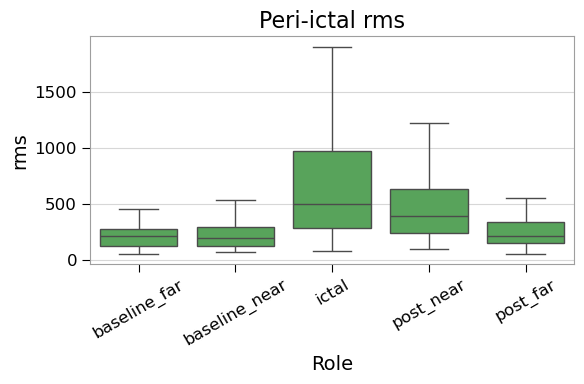

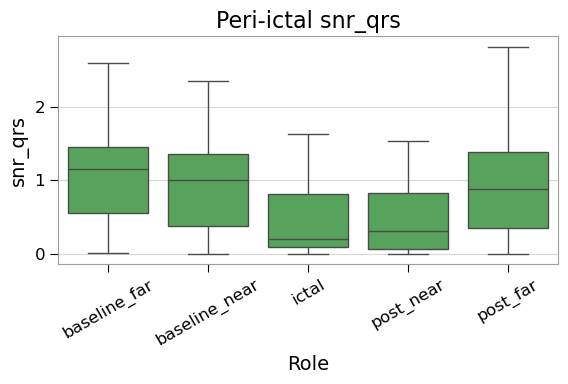

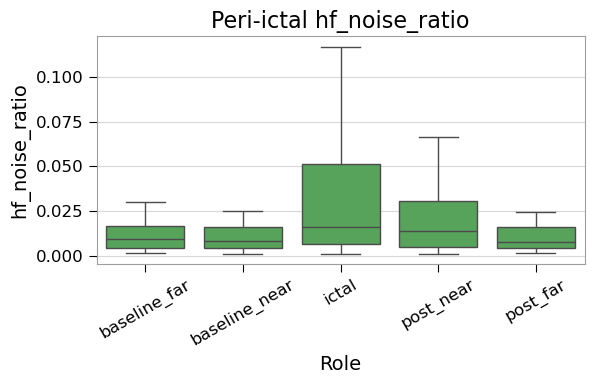

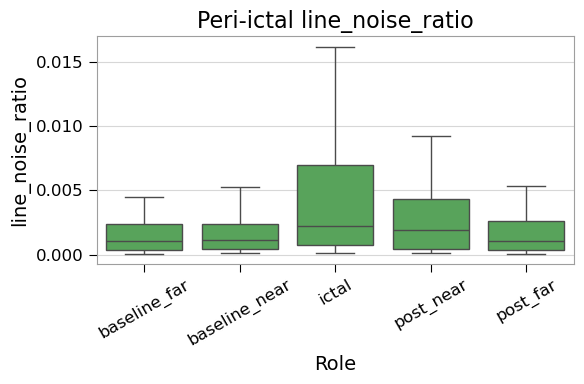

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_noise_ratio'}, xlabel='Role', ylabel='line_noise_ratio'>)

In [34]:
plot_peri_noise_feature(df_all, "rms")
plot_peri_noise_feature(df_all, "snr_qrs")
plot_peri_noise_feature(df_all, "hf_noise_ratio")
plot_peri_noise_feature(df_all, "line_noise_ratio")



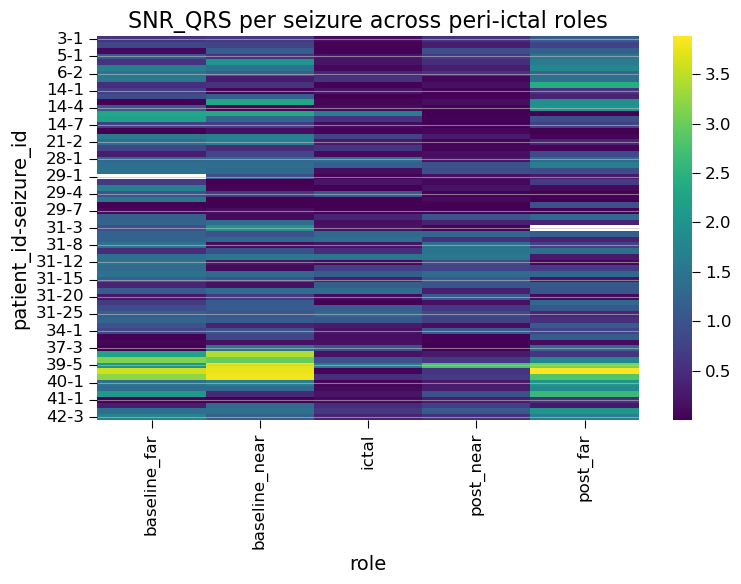

In [35]:
pivot_noise = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="snr_qrs"
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8,6))
sns.heatmap(pivot_noise, cmap="viridis")
plt.title("SNR_QRS per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3B PSD-analysis

In [36]:
[col for col in df_all.columns if "_power" in col or "_rel" in col]


['ulf_rel',
 'qrs_rel',
 'hf_rel',
 'line_rel',
 'ULF_power',
 'LF_power',
 'QRS-ish_power',
 'HF(40-100)_power',
 'Line(48-52)_power',
 'ULF_rel',
 'LF_rel',
 'QRS-ish_rel',
 'HF(40-100)_rel',
 'Line(48-52)_rel',
 'flag_hf_rel_ok',
 'flag_lf_rel_ok',
 'feat_lf_power',
 'feat_hf_power',
 'feat_mains_power',
 'feat_total_power',
 'feat_lf_rel_power',
 'feat_hf_rel_power',
 'feat_mains_rel_power']

In [37]:
psd_rel_cols = [c for c in df_all.columns if c.endswith("_rel")]

df_psd_role = (
    df_all
    .groupby("role")[psd_rel_cols]
    .agg(["median", "mean", "std"])
)

df_psd_role


ulf_rel                       qrs_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.112790  0.255695  0.290728  0.536003  0.457394  0.215903   
baseline_near  0.163055  0.303724  0.313247  0.500171  0.429771  0.229601   
ictal          0.570605  0.508845  0.295648  0.172253  0.249635  0.203921   
post_far       0.164268  0.313133  0.327411  0.470449  0.413319  0.231787   
post_near      0.504816  0.496083  0.305572  0.233845  0.266641  0.205515   

                 hf_rel                      line_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.002921  0.005983  0.008972  0.000333  0.000769  0.001047   
baseline_near  0.003050  0.007355  0.012794  0.000373  0.000936  0.001575   
ictal          0.002637  0.010884  0.020922  0.000332  0.001387  0.002842   
post_far       0.002101  0.006564  0.012257  0.000236  0.000886  0.001627   
post_near      0.001826  0.005831  0.017514  0.000213  0.000731  0.001905   

                ULF_rel                        LF_rel                      \
                 median      mean       std    median      mean       std   
role                                                                        
baseline_far   0.112790  0.255695  0.290728  0.285846  0.280546  0.107027   
baseline_near  0.163055  0.303724  0.313247  0.274395  0.258745  0.112036   
ictal          0.570605  0.508845  0.295648  0.206057  0.229765  0.155146   
post_far       0.164268  0.313133  0.327411  0.294257  0.266673  0.120555   
post_near      0.504816  0.496083  0.305572  0.211992  0.230981  0.123883   

              QRS-ish_rel                     HF(40-100)_rel            \
                   median      mean       std         median      mean   
role                                                                     
baseline_far     0.536003  0.457394  0.215903       0.002921  0.005983   
baseline_near    0.500171  0.429771  0.229601       0.003050  0.007355   
ictal            0.172253  0.249635  0.203921       0.002637  0.010884   
post_far         0.470449  0.413319  0.231787       0.002101  0.006564   
post_near        0.233845  0.266641  0.205515       0.001826  0.005831   

                        Line(48-52)_rel                      
                    std          median      mean       std  
role                                                         
baseline_far   0.008972        0.000333  0.000769  0.001047  
baseline_near  0.012794        0.000373  0.000936  0.001575  
ictal          0.020922        0.000332  0.001387  0.002842  
post_far       0.012257        0.000236  0.000886  0.001627  
post_near      0.017514        0.000213  0.000731  0.001905

In [38]:
df_psd_role_long = df_psd_role.stack(level=0).reset_index()
df_psd_role_long.head()


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_16188\3268273584.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_psd_role_long = df_psd_role.stack(level=0).reset_index()


,role,level_1,median,mean,std
0,baseline_far,HF(40-100)_rel,0.002921,0.005983,0.008972
1,baseline_far,LF_rel,0.285846,0.280546,0.107027
2,baseline_far,Line(48-52)_rel,0.000333,0.000769,0.001047
3,baseline_far,QRS-ish_rel,0.536003,0.457394,0.215903
4,baseline_far,ULF_rel,0.112790,0.255695,0.290728


3B.3 BoxPlots af PSD-rel-power pr rolle

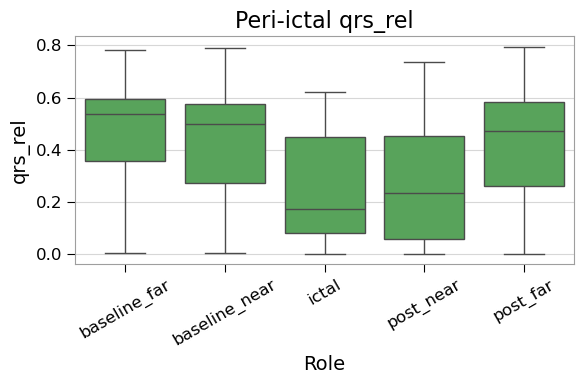

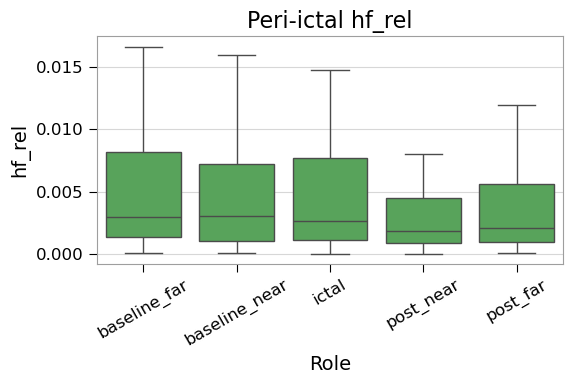

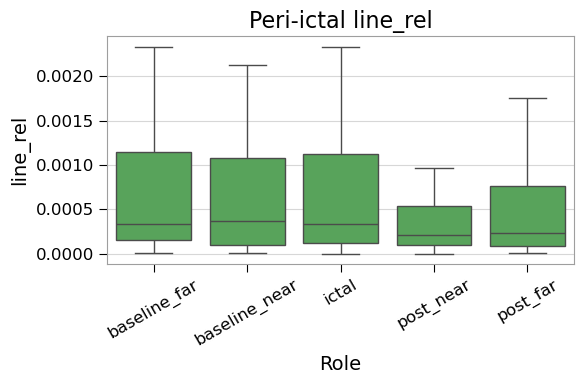

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal line_rel'}, xlabel='Role', ylabel='line_rel'>)

In [39]:
from src.hrv_epatch.plots.peri_psd import plot_peri_psd_feature

plot_peri_psd_feature(df_all, "qrs_rel")
plot_peri_psd_feature(df_all, "hf_rel")
plot_peri_psd_feature(df_all, "line_rel")

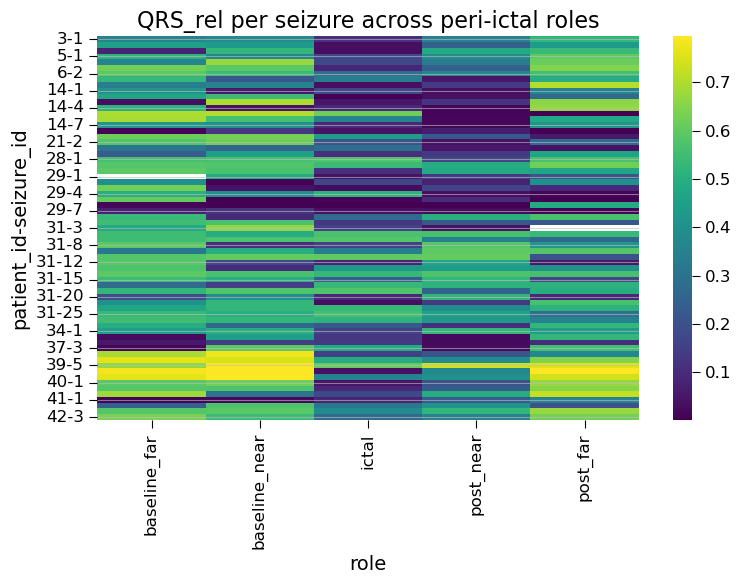

In [40]:
pivot_qrs = df_all.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="qrs_rel",
).reindex(columns=["baseline_far", "baseline_near", "ictal", "post_near", "post_far"])

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_qrs, cmap="viridis")
plt.title("QRS_rel per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


## 3C.1 

In [41]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

df_sqi_role = (
    df_sqi_full
    .groupby("role")
    .agg(
        n_windows=("is_good", "size"),
        n_good=("is_good", "sum"),
        median_sqi=("sqi_score", "median"),
        q1=("sqi_score", lambda x: x.quantile(0.25)),
        q3=("sqi_score", lambda x: x.quantile(0.75)),
    )
    .reindex(roles_order)
)

df_sqi_role["frac_good"] = df_sqi_role["n_good"] / df_sqi_role["n_windows"]
df_sqi_role["percent_good"] = 100 * df_sqi_role["frac_good"]

df_sqi_role


,n_windows,n_good,median_sqi,q1,q3,frac_good,percent_good
role,,,,,,,
baseline_far,69,61,1.0,1.0,1.0,0.884058,88.405797
baseline_near,70,63,1.0,1.0,1.0,0.900000,90.000000
ictal,70,56,1.0,1.0,1.0,0.800000,80.000000
post_near,70,63,1.0,1.0,1.0,0.900000,90.000000
post_far,69,59,1.0,1.0,1.0,0.855072,85.507246


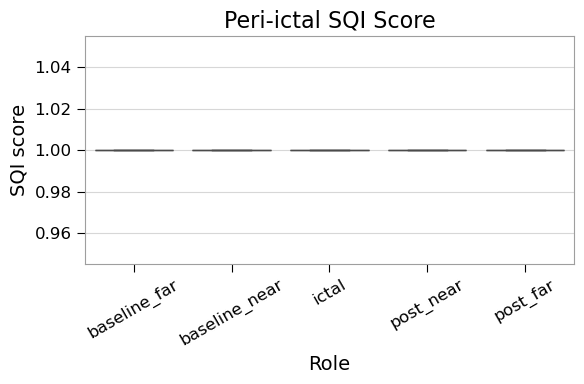

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Peri-ictal SQI Score'}, xlabel='Role', ylabel='SQI score'>)

In [42]:
plot_peri_sqi_score(df_sqi_full)


3C.3

In [43]:
sqi_bad = (
    df_sqi_full
    .groupby("role")["is_good"]
    .apply(lambda x: 1 - x.mean())
    .rename("frac_bad")
    .reindex(roles_order)
)

sqi_bad


role
baseline_far     0.115942
baseline_near    0.100000
ictal            0.200000
post_near        0.100000
post_far         0.144928
Name: frac_bad, dtype: float64

The fraction of SQI-poor windows was highest during ictal periods (12%), compared to 3–4% in the surrounding baseline windows, indicating a transient drop in signal quality during seizures.

3C.4

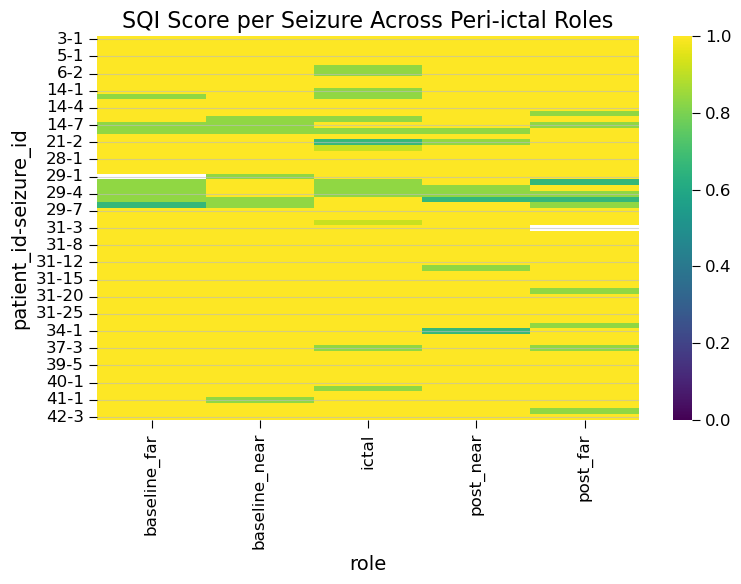

In [44]:
pivot_sqi = df_sqi_full.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="sqi_score"
).reindex(columns=roles_order)

plt.figure(figsize=(8,6))
sns.heatmap(pivot_sqi, cmap="viridis", vmin=0, vmax=1)
plt.title("SQI Score per Seizure Across Peri-ictal Roles")
plt.tight_layout()
plt.show()


3C.5

In [45]:
flag_cols = [c for c in df_sqi_full.columns if c.startswith("flag_")]

failure_rates = {}
for c in flag_cols:
    failure_rates[c] = 1 - df_sqi_full[c].mean()

pd.Series(failure_rates).sort_values(ascending=False)


flag_ramp_ok         0.051724
flag_flat_ok         0.051724
flag_amp_ok          0.011494
flag_mean_freq_ok    0.011494
flag_hf_rel_ok       0.011494
flag_lf_rel_ok       0.011494
dtype: float64

Across all peri-ictal windows, the most common failure mode of the SQI was low HF-relative power (6%), followed by amplitude differentiation (4%). All other criteria failed in <3% of windows

Step 4 - HRV

In [46]:
# Hvis alle vinduer har samme fs (512), kan vi bare bruge det direkte:
FS_GLOBAL = 512.0

segments = df_peri_valid["signal"].to_list()

hrv_feat_list = compute_hrv_for_many_segments(
    segments=segments,
    fs=FS_GLOBAL,
    min_peaks=3,
)

df_hrv = pd.DataFrame(hrv_feat_list)

# Merge metadata på (samme længde og rækkefølge som df_peri)
df_hrv_full = pd.concat(
    [
        df_peri_valid[["recording_uid", "patient_id", "seizure_id", "role"]].reset_index(drop=True),
        df_hrv.reset_index(drop=True),
    ],
    axis=1,
)

df_hrv_full.head()


,recording_uid,patient_id,seizure_id,role,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_SDANN1,HRV_HRV_SDNNI1,HRV_HRV_SDANN2,HRV_HRV_SDNNI2,HRV_HRV_SDANN5,HRV_HRV_SDNNI5,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_HRV_CVNN,HRV_HRV_CVSD,HRV_HRV_MedianNN,HRV_HRV_MadNN,HRV_HRV_MCVNN,HRV_HRV_IQRNN,HRV_HRV_SDRMSSD,HRV_HRV_Prc20NN,HRV_HRV_Prc80NN,HRV_HRV_pNN50,HRV_HRV_pNN20,HRV_HRV_MinNN,HRV_HRV_MaxNN,HRV_HRV_HTI,HRV_HRV_TINN,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R01,3,1,baseline_far,1064.524148,79.403034,NaN,NaN,NaN,NaN,NaN,NaN,36.422470,36.701317,0.074590,0.034215,1068.359375,69.496875,0.065050,91.796875,2.180056,1006.250000,1126.562500,14.545455,47.272727,878.906250,1234.375000,18.333333,179.6875,0.025952,0.109253,0.237538
1,P03_R01,3,1,baseline_near,1070.384838,43.373819,NaN,NaN,NaN,NaN,NaN,NaN,32.244146,32.541461,0.040522,0.030124,1073.242188,59.361914,0.055311,76.171875,1.345169,1032.421875,1117.968750,9.259259,55.555556,984.375000,1138.671875,9.000000,70.3125,0.023010,0.056860,0.404680
2,P03_R01,3,1,ictal,563.541667,108.615048,NaN,NaN,NaN,NaN,NaN,NaN,25.269118,23.115401,0.192736,0.044840,513.671875,31.852734,0.062010,85.937500,4.298332,495.703125,612.890625,6.666667,11.111111,490.234375,988.281250,5.000000,0.0000,0.016345,0.152733,0.107017
3,P03_R01,3,1,post_near,849.694293,43.719978,NaN,NaN,NaN,NaN,NaN,NaN,21.556061,21.715387,0.051454,0.025369,847.656250,43.435547,0.051242,60.546875,2.028199,818.359375,888.281250,1.449275,39.130435,748.046875,925.781250,6.900000,101.5625,0.015355,0.059892,0.256378
4,P03_R01,3,1,post_far,916.229248,22.523507,NaN,NaN,NaN,NaN,NaN,NaN,12.934517,13.014982,0.024583,0.014117,916.992188,23.165625,0.025263,32.226562,1.741349,894.531250,931.640625,0.000000,12.500000,875.000000,964.843750,6.400000,23.4375,0.009203,0.030495,0.301790


In [47]:
df_all_hrv = pd.merge(
    df_all,
    df_hrv_full,
    on=["recording_uid", "patient_id", "seizure_id", "role"],
    how="left",
)

df_all_hrv.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,...,HRV_HRV_SDNNI1,HRV_HRV_SDANN2,HRV_HRV_SDNNI2,HRV_HRV_SDANN5,HRV_HRV_SDNNI5,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_HRV_CVNN,HRV_HRV_CVSD,HRV_HRV_MedianNN,HRV_HRV_MadNN,HRV_HRV_MCVNN,HRV_HRV_IQRNN,HRV_HRV_SDRMSSD,HRV_HRV_Prc20NN,HRV_HRV_Prc80NN,HRV_HRV_pNN50,HRV_HRV_pNN20,HRV_HRV_MinNN,HRV_HRV_MaxNN,HRV_HRV_HTI,HRV_HRV_TINN,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R01,3,1,baseline_far,210.637327,0.000072,0.001386,0.552275,0.405070,0.355784,0.000493,0.000026,17922.689565,10554.423896,15741.998315,21.812142,1.137642,0.405070,0.238540,0.355784,0.000493,0.000026,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,36.422470,36.701317,0.074590,0.034215,1068.359375,69.496875,0.065050,91.796875,2.180056,1006.250000,1126.562500,14.545455,47.272727,878.906250,1234.375000,18.333333,179.6875,0.025952,0.109253,0.237538
1,P03_R01,3,1,baseline_near,202.085363,0.000094,0.001508,0.608736,0.357251,0.378394,0.000571,0.000036,13486.331773,9953.211881,14284.483368,21.545038,1.347034,0.357251,0.263659,0.378394,0.000571,0.000036,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,32.244146,32.541461,0.040522,0.030124,1073.242188,59.361914,0.055311,76.171875,1.345169,1032.421875,1117.968750,9.259259,55.555556,984.375000,1138.671875,9.000000,70.3125,0.023010,0.056860,0.404680
2,P03_R01,3,1,ictal,599.646820,0.003144,0.044018,0.119810,0.758620,0.106992,0.004710,0.000336,249212.299864,42049.752087,35147.501129,1547.128530,110.508775,0.758620,0.128003,0.106992,0.004710,0.000336,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,25.269118,23.115401,0.192736,0.044840,513.671875,31.852734,0.062010,85.937500,4.298332,495.703125,612.890625,6.666667,11.111111,490.234375,988.281250,5.000000,0.0000,0.016345,0.152733,0.107017
3,P03_R01,3,1,post_near,273.332578,0.000516,0.004729,0.535436,0.403244,0.348719,0.001649,0.000180,25362.290996,15473.692855,21932.931488,103.715395,11.321012,0.403244,0.246021,0.348719,0.001649,0.000180,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,21.556061,21.715387,0.051454,0.025369,847.656250,43.435547,0.051242,60.546875,2.028199,818.359375,888.281250,1.449275,39.130435,748.046875,925.781250,6.900000,101.5625,0.015355,0.059892,0.256378
4,P03_R01,3,1,post_far,186.527336,0.000117,0.001951,1.100059,0.142168,0.523823,0.001022,0.000061,4540.663631,10628.137450,16730.233579,32.632829,1.958542,0.142168,0.332767,0.523823,0.001022,0.000061,True,1.0,True,...,NaN,NaN,NaN,NaN,NaN,12.934517,13.014982,0.024583,0.014117,916.992188,23.165625,0.025263,32.226562,1.741349,894.531250,931.640625,0.000000,12.500000,875.000000,964.843750,6.400000,23.4375,0.009203,0.030495,0.301790


4B.1 - Trim HRV-features and show results

In [48]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

short_hrv_cols = [
    "HRV_HRV_MeanNN",
    "HRV_HRV_SDNN",
    "HRV_HRV_RMSSD",
    "HRV_HRV_SDSD",
    "HRV_SD1_manual",
    "HRV_SD2_manual",
    "HRV_SD1SD2_manual",
]

df_hrv_short = df_hrv_full[
    ["recording_uid", "patient_id", "seizure_id", "role"] + short_hrv_cols
].copy()

df_hrv_short.head()


,recording_uid,patient_id,seizure_id,role,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R01,3,1,baseline_far,1064.524148,79.403034,36.422470,36.701317,0.025952,0.109253,0.237538
1,P03_R01,3,1,baseline_near,1070.384838,43.373819,32.244146,32.541461,0.023010,0.056860,0.404680
2,P03_R01,3,1,ictal,563.541667,108.615048,25.269118,23.115401,0.016345,0.152733,0.107017
3,P03_R01,3,1,post_near,849.694293,43.719978,21.556061,21.715387,0.015355,0.059892,0.256378
4,P03_R01,3,1,post_far,916.229248,22.523507,12.934517,13.014982,0.009203,0.030495,0.301790


## 4B.2 - HRV Results

In [49]:
roles_order = ["baseline_far", "baseline_near", "ictal", "post_near", "post_far"]

short_hrv_cols = [
    "HRV_HRV_MeanNN",
    "HRV_HRV_SDNN",
    "HRV_HRV_RMSSD",
    "HRV_HRV_SDSD",
    "HRV_SD1_manual",
    "HRV_SD2_manual",
    "HRV_SD1SD2_manual",
]

grp = df_hrv_short.groupby("role")[short_hrv_cols]

df_hrv_role = grp.agg(
    [
        "median",
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75),
    ]
).reindex(roles_order)

# Gør kolonnenavnene lidt pænere (optional)
df_hrv_role.columns = df_hrv_role.columns.set_levels(
    ["median", "q1", "q3"], level=1
)

df_hrv_role



HRV_HRV_MeanNN                         HRV_HRV_SDNN             \
                      median          q1          q3       median         q1   
role                                                                           
baseline_far      740.531052  669.788707  858.299366    43.163331  27.155701   
baseline_near     736.157227  665.482955  831.591797    41.354045  26.944590   
ictal             642.894561  528.176509  701.527322    84.729420  40.882662   
post_near         661.864564  520.106352  720.697170    51.648032  29.447497   
post_far          673.672763  626.911569  790.546875    31.528611  19.215737   

                          HRV_HRV_RMSSD                        HRV_HRV_SDSD  \
                       q3        median         q1          q3       median   
role                                                                          
baseline_far    61.142046     19.269824  15.032123   34.988918    19.376962   
baseline_near   62.239389     21.224820  15.565463   36.994013    21.319020   
ictal          176.599396     26.377362  11.565007  202.171183    26.445174   
post_near      105.389435     24.107504  13.630949  110.698094    24.192531   
post_far        49.609270     16.287740   9.866665   27.994133    16.358471   

                                     HRV_SD1_manual                      \
                      q1          q3         median        q1        q3   
role                                                                      
baseline_far   15.130501   35.328246       0.013702  0.010699  0.024981   
baseline_near  15.639606   37.244818       0.015075  0.011059  0.026336   
ictal          11.637891  203.203682       0.018700  0.008229  0.143687   
post_near      13.709045  111.355309       0.017107  0.009694  0.078740   
post_far        9.912562   28.199092       0.011567  0.007009  0.019940   

              HRV_SD2_manual                     HRV_SD1SD2_manual            \
                      median        q1        q3            median        q1   
role                                                                           
baseline_far        0.055307  0.036046  0.076137          0.301241  0.228626   
baseline_near       0.053263  0.034319  0.080292          0.342703  0.229307   
ictal               0.115927  0.056576  0.200404          0.332229  0.115892   
post_near           0.068900  0.040464  0.126338          0.294771  0.192472   
post_far            0.040878  0.025422  0.059668          0.293416  0.224134   

                         
                     q3  
role                     
baseline_far   0.415768  
baseline_near  0.579447  
ictal          0.635866  
post_near      0.653200  
post_far       0.498027

RMSSD and SD1 were lower during ictal windows compared to pre-ictal baseline, indicating reduced short-term variability during seizures

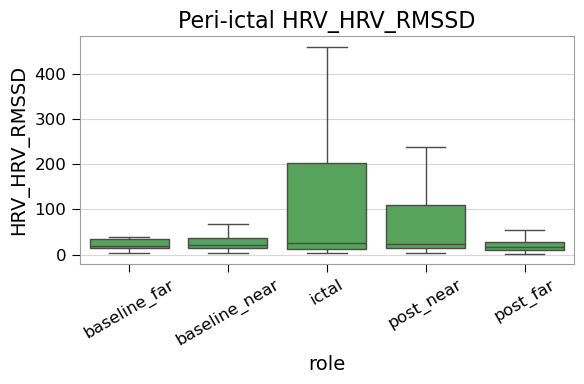

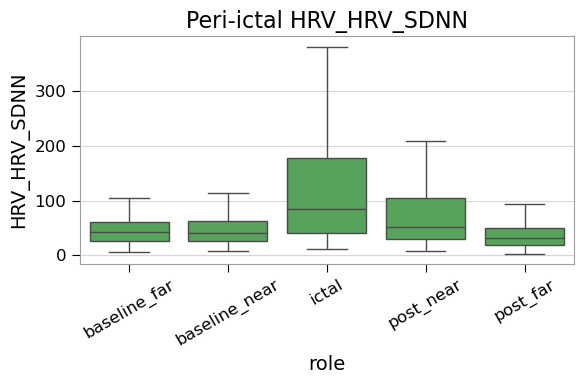

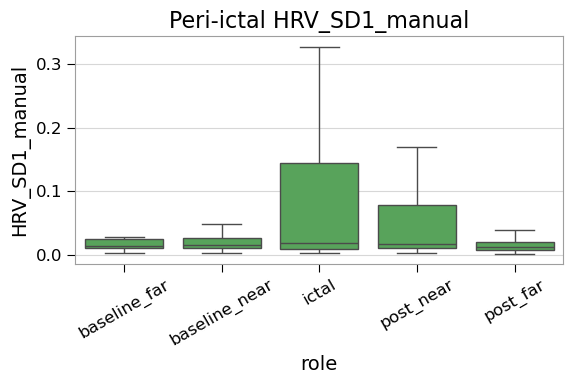

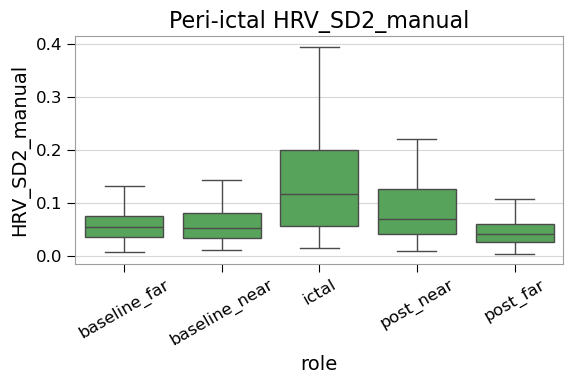

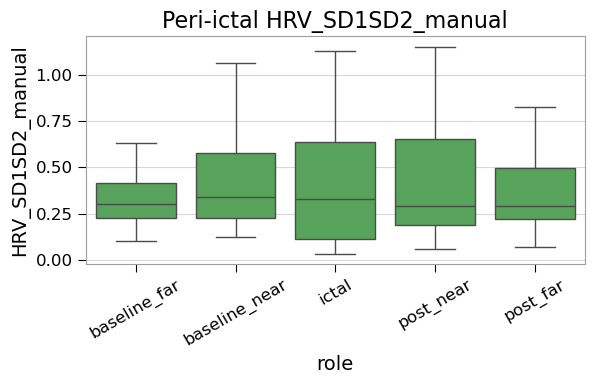

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hrv_feature(feature: str):
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df_hrv_short,
        x="role",
        y=feature,
        order=roles_order,
        showfliers=False,
    )
    plt.title(f"Peri-ictal {feature}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Eksempler:
plot_hrv_feature("HRV_HRV_RMSSD")
plot_hrv_feature("HRV_HRV_SDNN")
plot_hrv_feature("HRV_SD1_manual")
plot_hrv_feature("HRV_SD2_manual")
plot_hrv_feature("HRV_SD1SD2_manual")


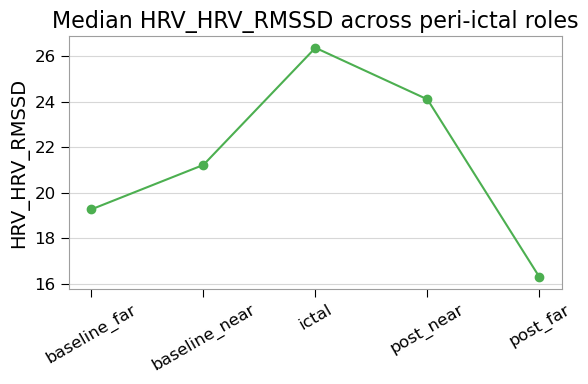

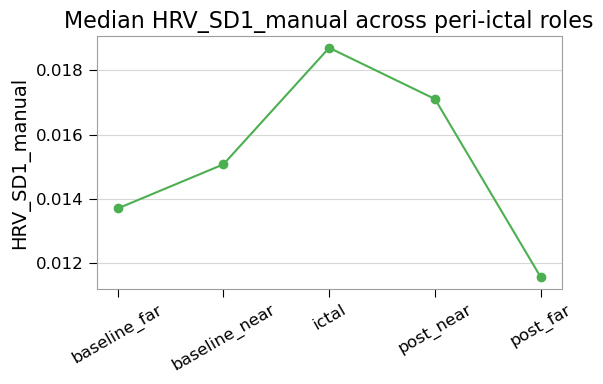

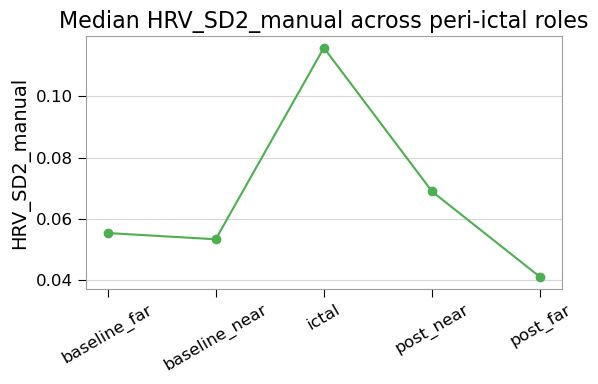

In [51]:
def plot_hrv_median_curve(feature: str):
    med = (
        df_hrv_short
        .groupby("role")[feature]
        .median()
        .reindex(roles_order)
    )

    plt.figure(figsize=(6, 4))
    plt.plot(roles_order, med.values, marker="o")
    plt.title(f"Median {feature} across peri-ictal roles")
    plt.ylabel(feature)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

plot_hrv_median_curve("HRV_HRV_RMSSD")
plot_hrv_median_curve("HRV_SD1_manual")
plot_hrv_median_curve("HRV_SD2_manual")


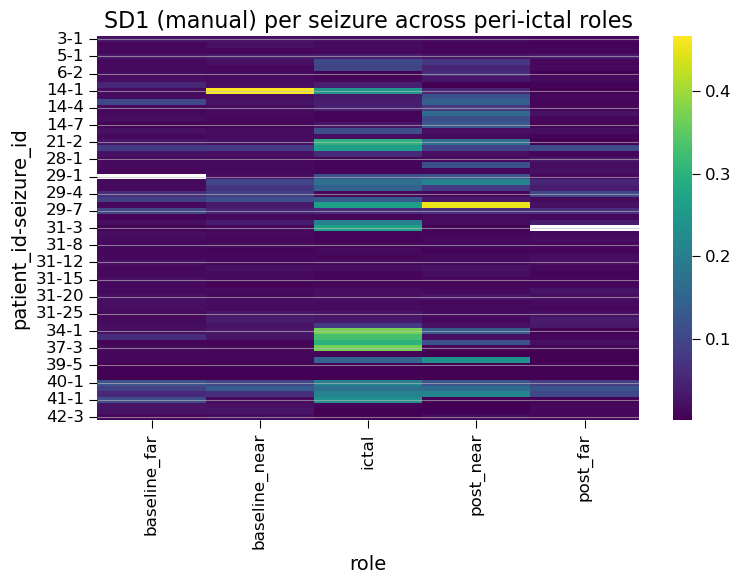

In [52]:
pivot_sd1 = df_hrv_short.pivot_table(
    index=["patient_id", "seizure_id"],
    columns="role",
    values="HRV_SD1_manual",        # "HRV_SD1_manual", "HRV_HRV_RMSSD","HRV_SD2_manual",
).reindex(columns=roles_order)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_sd1, cmap="viridis")
plt.title("SD1 (manual) per seizure across peri-ictal roles")
plt.tight_layout()
plt.show()


Merge HRV into df_all --> df_all_hrv

In [53]:
# Hvis du vil bruge den trimmede HRV-tabel:
df_hrv_short = df_hrv_full[
    ["recording_uid", "patient_id", "seizure_id", "role",
     "HRV_HRV_MeanNN", "HRV_HRV_SDNN", "HRV_HRV_RMSSD",
     "HRV_HRV_SDSD", "HRV_SD1_manual", "HRV_SD2_manual", "HRV_SD1SD2_manual"]
].copy()

df_all_hrv = pd.merge(
    df_all,
    df_hrv_short,
    on=["recording_uid", "patient_id", "seizure_id", "role"],
    how="left",
)

df_all_hrv.head()


,recording_uid,patient_id,seizure_id,role,rms,line_noise_ratio,hf_noise_ratio,snr_qrs,ulf_rel,qrs_rel,hf_rel,line_rel,ULF_power,LF_power,QRS-ish_power,HF(40-100)_power,Line(48-52)_power,ULF_rel,LF_rel,QRS-ish_rel,HF(40-100)_rel,Line(48-52)_rel,is_good,sqi_score,flag_amp_ok,flag_ramp_ok,flag_mean_freq_ok,flag_hf_rel_ok,flag_lf_rel_ok,flag_flat_ok,feat_ampdiff,feat_rampdiff,feat_mean_freq,feat_lf_power,feat_hf_power,feat_mains_power,feat_total_power,feat_lf_rel_power,feat_hf_rel_power,feat_mains_rel_power,feat_flat_rampdiff_min,feat_flat_rampdiff_p10,HRV_HRV_MeanNN,HRV_HRV_SDNN,HRV_HRV_RMSSD,HRV_HRV_SDSD,HRV_SD1_manual,HRV_SD2_manual,HRV_SD1SD2_manual
0,P03_R01,3,1,baseline_far,210.637327,0.000072,0.001386,0.552275,0.405070,0.355784,0.000493,0.000026,17922.689565,10554.423896,15741.998315,21.812142,1.137642,0.405070,0.238540,0.355784,0.000493,0.000026,True,1.0,True,True,True,True,True,True,1782.949752,1328.256229,5.677035,7846.030202,21.671499,0.539655,34544.547292,0.227128,0.000627,0.000016,887.341299,913.796194,1064.524148,79.403034,36.422470,36.701317,0.025952,0.109253,0.237538
1,P03_R01,3,1,baseline_near,202.085363,0.000094,0.001508,0.608736,0.357251,0.378394,0.000571,0.000036,13486.331773,9953.211881,14284.483368,21.545038,1.347034,0.357251,0.263659,0.378394,0.000571,0.000036,True,1.0,True,True,True,True,True,True,1631.385245,1165.668849,5.907381,5563.503509,21.186772,0.724545,30173.457700,0.184384,0.000702,0.000024,843.249805,929.503789,1070.384838,43.373819,32.244146,32.541461,0.023010,0.056860,0.404680
2,P03_R01,3,1,ictal,599.646820,0.003144,0.044018,0.119810,0.758620,0.106992,0.004710,0.000336,249212.299864,42049.752087,35147.501129,1547.128530,110.508775,0.758620,0.128003,0.106992,0.004710,0.000336,True,1.0,True,True,True,True,True,True,4761.881254,2728.161135,2.947310,151462.310491,1832.065563,61.621458,250826.236071,0.603854,0.007304,0.000246,901.119890,1100.082753,563.541667,108.615048,25.269118,23.115401,0.016345,0.152733,0.107017
3,P03_R01,3,1,post_near,273.332578,0.000516,0.004729,0.535436,0.403244,0.348719,0.001649,0.000180,25362.290996,15473.692855,21932.931488,103.715395,11.321012,0.403244,0.246021,0.348719,0.001649,0.000180,True,1.0,True,True,True,True,True,True,2557.306600,1818.774090,5.673694,12693.179981,98.147108,4.551388,51634.340301,0.245828,0.001901,0.000088,733.021073,984.067012,849.694293,43.719978,21.556061,21.715387,0.015355,0.059892,0.256378
4,P03_R01,3,1,post_far,186.527336,0.000117,0.001951,1.100059,0.142168,0.523823,0.001022,0.000061,4540.663631,10628.137450,16730.233579,32.632829,1.958542,0.142168,0.332767,0.523823,0.001022,0.000061,True,1.0,True,True,True,True,True,True,1556.980850,1179.447440,7.110352,1711.358458,33.130576,1.029366,29177.562242,0.058653,0.001135,0.000035,879.074144,928.125930,916.229248,22.523507,12.934517,13.014982,0.009203,0.030495,0.301790


In [54]:
OUT_DIR.mkdir(parents=True, exist_ok=True)
df_all_hrv.to_parquet(OUT_DIR / "study3_peri_features.parquet")
df_all_hrv.to_csv(OUT_DIR / "study3_peri_features.csv", index=False)

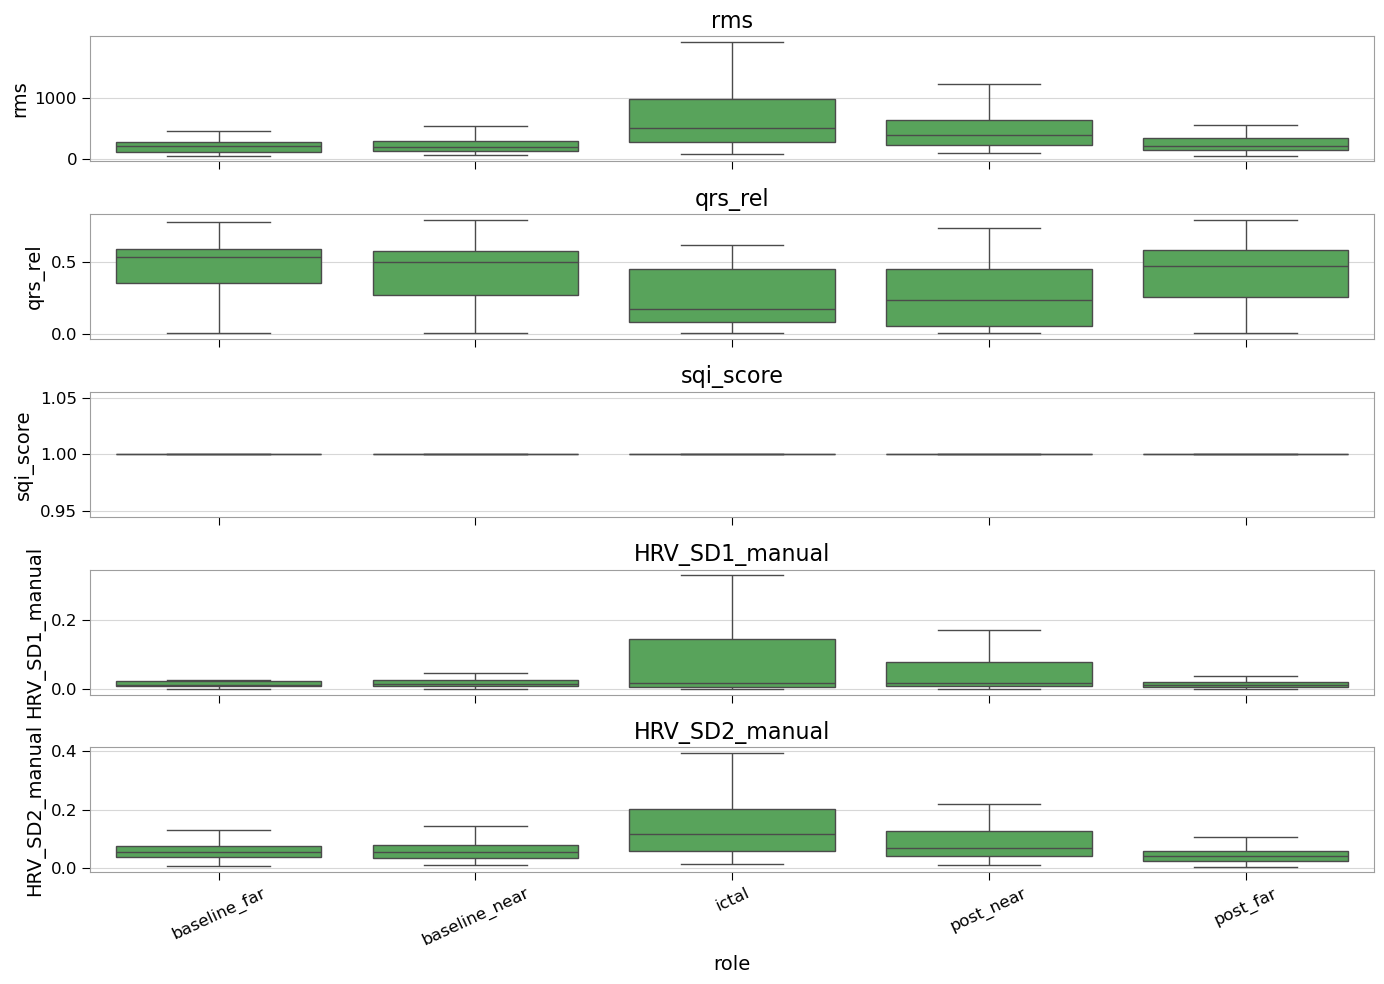

(<Figure size 1400x1000 with 5 Axes>,
 array([<Axes: title={'center': 'rms'}, xlabel='role', ylabel='rms'>,
        <Axes: title={'center': 'qrs_rel'}, xlabel='role', ylabel='qrs_rel'>,
        <Axes: title={'center': 'sqi_score'}, xlabel='role', ylabel='sqi_score'>,
        <Axes: title={'center': 'HRV_SD1_manual'}, xlabel='role', ylabel='HRV_SD1_manual'>,
        <Axes: title={'center': 'HRV_SD2_manual'}, xlabel='role', ylabel='HRV_SD2_manual'>],
       dtype=object))

In [55]:
from src.hrv_epatch.plots.peri_summary import plot_peri_summary, plot_peri_median_curves

selected_features = [
    "rms",            # noise metric
    "qrs_rel",        # PSD / morphology
    "sqi_score",      # signal quality
    "HRV_SD1_manual", # HRV (short-term variability)
    "HRV_SD2_manual"
]

plot_peri_summary(df_all_hrv, selected_features)


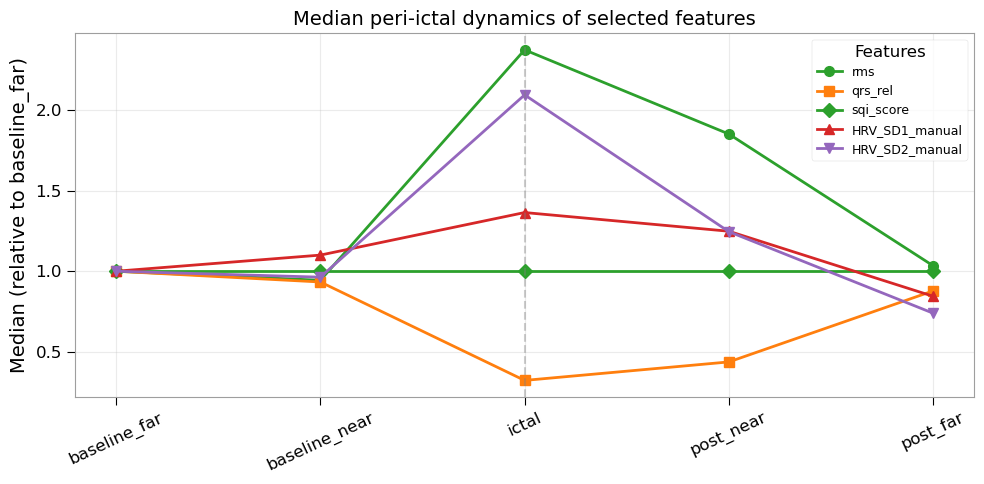

In [56]:
selected_features = ["rms", "qrs_rel", "sqi_score", "HRV_SD1_manual", "HRV_SD2_manual"]
plot_peri_median_curves(df_all_hrv, selected_features, figsize=(10,5))


Peri-ictal RMS values increased sharply during ictal periods, with both median and mean values peaking substantially in the ictal window.
The difference between median and mean indicates the presence of high-amplitude artefacts (e.g., muscle activation) during seizures.

Short-term HRV metrics (SD1, SD2) were consistently lower during ictal periods, suggesting reduced short-term autonomic variability during the seizure itself.

The ictal window contains a small number of extreme values (artefacts),visible in the mean curve, but largely suppressed in the median curve.

In [57]:
from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet

fs = 512.0
plot_peri_cwt_triplet(df_peri_valid, fs, patient_id=1, seizure_id=1)


ValueError: Missing one or more peri-ictal windows.

Explorativ CWT walkthroug.

In [ ]:
# from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet

# fs = 512.0

# unique_seizures = (
#     df_peri_valid[["patient_id", "seizure_id"]]
#     .drop_duplicates()
#     .sort_values(["patient_id", "seizure_id"])
# )

# for _, row in unique_seizures.iterrows():
#     pid = row["patient_id"]
#     sid = row["seizure_id"]
#     print(f"Plotting Patient {pid}, Seizure {sid}")
#     try:
#         plot_peri_cwt_triplet(df_peri_valid, fs, patient_id=pid, seizure_id=sid)
#     except ValueError as e:
#         print("  Skipping:", e)
#         continue
    
#     # stop manuelt hvis du vil:
#     cont = input("Næste? (Enter = ja, q = stop) ")
#     if cont.lower().startswith("q"):
#         break


Alternative CWT analysis for all seizures in all patients and save local.

In [ ]:
from pathlib import Path
from src.hrv_epatch.plots.peri_wavelet import plot_peri_cwt_triplet
from src.hrv_epatch.plots.peri_wavelet_dwt import plot_dwt_triplet

OUT_ROOT = Path(r"E:\Speciale - Results")
OUT_CWT = OUT_ROOT / "cwt_peri"
OUT_DWT = OUT_ROOT / "dwt_peri"
OUT_CWT.mkdir(parents=True, exist_ok=True)
OUT_DWT.mkdir(parents=True, exist_ok=True)

fs = 512.0  # eller df_peri_valid["fs"].iloc[0] hvis du vil læse dynamisk

# Unikke (patient, seizure)-par
unique_seizures = (
    df_peri_valid[["patient_id", "seizure_id"]]
    .drop_duplicates()
    .sort_values(["patient_id", "seizure_id"])
)

print(f"Processing {len(unique_seizures)} seizures...\n")

for _, row in unique_seizures.iterrows():
    pid = int(row["patient_id"])
    sid = int(row["seizure_id"])

    print(f"P{pid:02d} S{sid:02d} ... ", end="")

    # Filnavne
    cwt_path = OUT_CWT / f"CWT_P{pid:02d}_S{sid:02d}.png"
    dwt_path = OUT_DWT / f"DWT_P{pid:02d}_S{sid:02d}.png"

    try:
        # CWT-triple (baseline_near, ictal, post_near)
        plot_peri_cwt_triplet(
            df_peri=df_peri_valid,
            fs=fs,
            patient_id=pid,
            seizure_id=sid,
            save_path=cwt_path,
            show_plot=False,   # <- ingen visning
        )

        # DWT-triple (samme vinduer)
        plot_dwt_triplet(
            df_peri=df_peri_valid,
            fs=fs,
            patient_id=pid,
            seizure_id=sid,
            save_path=dwt_path,
            show_plot=False,   # <- ingen visning
        )

        print("saved.")
    except Exception as e:
        print(f"skipped ({e}).")

print("\nDone.")


Processing 146 seizures...

P01 S01 ... saved.
P01 S02 ... saved.
P01 S03 ... saved.
P02 S01 ... saved.
P02 S02 ... saved.
P02 S03 ... saved.
P02 S04 ... saved.
P02 S05 ... saved.
P02 S07 ... saved.
P02 S08 ... saved.
P02 S09 ... saved.
P02 S10 ... saved.
P03 S01 ... saved.
P03 S02 ... saved.
P03 S03 ... saved.
P04 S01 ... saved.
P05 S01 ... saved.
P05 S02 ... saved.
P05 S03 ... saved.
P06 S02 ... saved.
P07 S01 ... saved.
P07 S02 ... saved.
P07 S03 ... saved.
P07 S04 ... saved.
P08 S01 ... saved.
P09 S01 ... saved.
P09 S02 ... saved.
P09 S03 ... saved.
P10 S01 ... saved.
P11 S01 ... saved.
P11 S02 ... saved.
P11 S03 ... saved.
P11 S04 ... saved.
P11 S05 ... saved.
P11 S06 ... saved.
P12 S01 ... saved.
P12 S02 ... saved.
P12 S03 ... saved.
P13 S01 ... saved.
P13 S02 ... saved.
P13 S03 ... saved.
P13 S04 ... saved.
P13 S05 ... saved.
P13 S06 ... saved.
P13 S15 ... saved.
P13 S25 ... saved.
P14 S01 ... saved.
P14 S02 ... saved.
P14 S03 ... saved.
P14 S04 ... saved.
P14 S05 ... saved.
P14

## 8. Noise and spectral characteristics

We complement the SQI analysis with PSD-based noise metrics and bandpower
profiles for selected segments / patients.

## 9. Peri-ictal windows around seizures

In addition to the global 60 s segmentation, we construct peri-ictal windows
around each seizure to study how signal characteristics change before, during,
and after clinical events.

We reuse the previous scheme:
- seizure-only windows (matching seizure duration)
- seizure ±2 minutes
- “clean” baseline windows ~20 minutes before seizure

## 10. Case-study plots

Finally, we generate a small number of illustrative plots for selected seizures:
- raw vs cleaned ECG with R-peaks from different detectors
- peri-ictal scalograms / PSD
- segment-level SQI and noise metrics across time

## 11. Export of tables and figures

We finally export the key tables and figures used in the thesis, so that the
LaTeX document can include them directly.